## Integrantes

- **Estudiante 1:** Juan David Duarte Yara - 202215070
- **Estudiante 2:** Luisa Gabriela Hernández Pérez - 202114093
- **Estudiante 3:** Juan Sebastian Sanchez - 202121498
- Todos los estudiantes aportaron en las partes generales del notebook y en las diapositivas de coclusiones.



## 0. Carga de los datos. 

### 0.1. Importación de librerías 

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [988]:
# Importaciones de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
import re
import string
import unicodedata

# Importaciones de joblib
from joblib import dump, load

# Importaciones de sklearn
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Clasificacion
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

# Importaciones de statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Importaciones de nltk
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer, SnowballStemmer

# Instalación de paquetes adicionales
import contractions

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV

# Para la validación cruzada
from sklearn.model_selection import KFold

### 0.2. Lectura de archivos
A través de la librería **pandas** podemos realizar la carga de datos desde diferentes fuentes de información, en este caso se realizará la carga de un archivo plano csv (archivo separado por comas).

In [989]:
# Se cargan los datos. 
datatrain=pd.read_csv('fake_news_spanish.csv', sep=';', encoding = 'utf-8', nrows=2000)
datatest = pd.read_csv('fake_news_test.csv', sep=';', encoding = 'utf-8')

Podemos ver que hay 57,063 filas y 5 columnas de atributos en el conjunto de entrenamiento

In [990]:
datatrain.shape

(2000, 5)

Podemos ver que hay 1000 filas y 4 columnas de atributos en el conjunto de prueba

In [991]:
datatest.shape

(1000, 4)

Veamos un pequeño sample de los datos

In [992]:
datatrain.sample(10)

,ID,Label,Titulo,Descripcion,Fecha
1197,ID,1,Las diez medidas sociales más destacadas del p...,Además de la subida del SMI y del incremento d...,11/10/2018
1058,ID,0,El juez de Valtonyc se queja en 'La Razón' de ...,"Florentino Pérez, recusado de la Gürtel por su...",26/02/2018
1777,ID,1,Ayuso ganaría las elecciones en Madrid si hubi...,El PP volvería a ser la primera fuerza por del...,24/06/2020
190,ID,1,Así pasan los candidatos a las elecciones en M...,Repasamos los planes de los cabezas de las lis...,03/05/2021
696,ID,1,El Supremo anula por discriminación el despido...,Esta práctica afecta a miles de docentes de ce...,13/06/2018
1083,ID,1,Monedero critica a Errejón tras los tres escañ...,El cofundador de Podemos ha acusado a su excom...,11/11/2019
491,ID,1,"Vivienda, sanidad, educación y migraciones: ¿Q...",Las formaciones pugnan en estos comicios por r...,19/04/2021
104,ID,1,"Héctor Illueca, candidato de Unides Podem a la...",El vicepresidente segundo asegura que la medid...,21/05/2023
484,ID,1,El Ayuntamiento no le ve 'sentido' a recurrir ...,Acatamos y respetamos absolutamente todas las ...,18/07/2019
937,ID,1,El ayuntamiento de Bilbao quiere mantener las ...,El movimiento antitaurino volverá a movilizars...,24/08/2019


Revisemos que el tipo de dato sea el esperado

In [993]:
datatrain.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

In [994]:
datatrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2000 non-null   object
 1   Label        2000 non-null   int64 
 2   Titulo       2000 non-null   object
 3   Descripcion  2000 non-null   object
 4   Fecha        2000 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


---


# 2. Entendimiento de los datos

## 2.1 Analisis descriptivo

Podemos ver que hay textos repetidos

In [995]:
datatrain["Descripcion"].describe()


count                                                  2000
unique                                                 1994
top       Los populares aseguran haber recibido un anóni...
freq                                                      2
Name: Descripcion, dtype: object

Es útil saber que tan largos son los textos

In [996]:
datatrain["Descripcion"].apply(len).describe()

count    2000.000000
mean      247.199000
std       272.148176
min        52.000000
25%       176.000000
50%       223.000000
75%       267.000000
max      9117.000000
Name: Descripcion, dtype: float64

Los textos tienen una longitud entre 33 y 14,153 caracteres, con una media de 243 caracteres. 

Queremos ver ahora la columna "label"

In [997]:
datatrain["Label"].describe()

count    2000.000000
mean        0.590500
std         0.491865
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Label, dtype: float64

Podemos ver que efectivamente la columna "Label" tiene valores entre 0 y 1.

Nos gustaría saber la proporción que hay entre noticias falsas y las que no

In [998]:
datatrain["Label"].value_counts()

Label
1    1181
0     819
Name: count, dtype: int64

Podemos ver que los datos están ligeramente desbalanceados

In [999]:
datatrain.head(2)


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023


In [1000]:
datatrain[["Titulo", "Descripcion"]].head(2)

,Titulo,Descripcion
0,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...
1,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...


Estadisticas de cada registro del tamaño del texto concatenado entre 
- *Conteo total:* titulo + descripcion
- *Conteo titulo:* titulo 
- *Conteo descripcion:*  descripcion
- *Min* : palabra mas corta de cada registro
- *Max* : palabra mas larga de cada registro


In [1001]:
textos = datatrain.copy()
textos["Message"] = (textos["Titulo"] + " " + textos["Descripcion"]).astype(str)

textos["Conteo total"] = textos["Message"].str.len()
textos["Conteo titulo"] = textos["Titulo"].str.len()
textos["Conteo descripcion"] = textos["Descripcion"].str.len()

textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Message']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Message']]

textos[["Conteo total", "Conteo titulo", "Conteo descripcion", "Max", "Min"]].describe()

,Conteo total,Conteo titulo,Conteo descripcion,Max,Min
count,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,342.82500,94.626000,247.199000,13.083000,1.068000
std,273.20922,22.023797,272.148176,2.006022,0.270948
min,122.00000,29.000000,52.000000,8.000000,0.000000
25%,268.75000,80.000000,176.000000,12.000000,1.000000
50%,316.00000,94.000000,223.000000,13.000000,1.000000
75%,368.00000,110.000000,267.000000,14.000000,1.000000
max,9214.00000,212.000000,9117.000000,27.000000,2.000000


## 2.2 Calidad de datos

In [1002]:
# Es recomendable que todos los pasos de limpieza y preparación se realicen sobre otro archivo.
data_t = datatrain.copy()

### Unicidad

Revisemos los duplicados por título 

In [1003]:
data_t.loc[datatrain.duplicated(subset= "Titulo", keep = False)].sort_values("Titulo").head(10)

,ID,Label,Titulo,Descripcion,Fecha
1291,ID,1,El Ayuntamiento de Palma investiga una supuest...,En la fiesta para homenajear a un policía a pu...,21/04/2021
1771,ID,0,El Ayuntamiento de Palma investiga una supuest...,En la fiesta para homenajear a un policía a pu...,21/04/2021
118,ID,1,"El juicio por la salida a Bolsa de Bankia, sus...",El Tribunal de la Audiencia Nacional que presi...,11/01/2019
957,ID,0,"El juicio por la salida a Bolsa de Bankia, sus...",El Tribunal de la Audiencia Nacional que presi...,11/01/2019
121,ID,0,Jorge Moragas será el embajador de España en F...,El que fuera director de gabinete de José Miño...,18/07/2018
1330,ID,1,Jorge Moragas será el embajador de España en F...,El que fuera director de gabinete de Mariano R...,18/07/2018
636,ID,0,Los largos cinco días en los que el Gobierno n...,Desde Moncloa se han aferrado durante toda la ...,22/04/2022
836,ID,1,Los largos cinco días en los que el Gobierno n...,Desde Moncloa se han aferrado durante toda la ...,22/04/2022


Revisemos ahora los duplicados por descripción 

In [1004]:
data_t.loc[datatrain.duplicated(subset= "Descripcion", keep = False)].sort_values("Descripcion").head(10)

,ID,Label,Titulo,Descripcion,Fecha
666,ID,0,"El legado del BNG en Madrid: desigualdad, anem...",A lo largo de la campaña se hablará más en cla...,19/04/2021
1551,ID,1,"El legado del PP en Madrid: desigualdad, anemi...",A lo largo de la campaña se hablará más en cla...,19/04/2021
483,ID,0,Torrent pide al juez Llarena que facilite que ...,El presidente del Parlament ha enviado una car...,08/03/2018
1813,ID,1,Torrent pide al juez Llarena que facilite que ...,El presidente del Parlament ha enviado una car...,08/03/2018
11,ID,1,Ayuso dice que las muertes en las residencias ...,La única manera es actuar de la misma manera u...,15/06/2020
962,ID,0,Carlos Prieto dice que las muertes en las resi...,La única manera es actuar de la misma manera u...,15/06/2020
1780,ID,1,El PSOE decide que esta legislatura se apruebe...,Las feministas introdujeron una enmienda para ...,16/10/2021
1829,ID,0,El Nueva Canarias decide que esta legislatura ...,Las feministas introdujeron una enmienda para ...,16/10/2021
812,ID,1,Lista continuista de Barcelona en Comú para la...,"Los concejales Gemma Tarafa, Lucía Martín, Mar...",11/02/2023
1794,ID,0,Lista continuista de Barcelona en Comú para la...,"Los concejales Gemma Tarafa, Lucía Martín, Mar...",11/02/2023


In [1005]:
data_t.duplicated(keep=False).sum()

np.int64(0)

Revisando el archivo pudimos notar que realmente los anteriores datos no son duplicados, sino que tienen ligeras diferencias entre su contenido, reafirmando que uno es una fake news y la otra no.

Ahora revisemos cuando la columna "Titulo", "Descripcción","Fecha" y "Label" son exactamente iguales.

In [1006]:
data_t.loc[datatrain.duplicated(subset= ["Descripcion","Titulo"], keep = False)].sort_values("Descripcion").head(10)

,ID,Label,Titulo,Descripcion,Fecha


Todas estas instancias son exactamente iguales, por lo cual, son duplicados. Revisemos cuantos duplicados realmente hay.

In [1007]:
data_t.duplicated(subset=['Titulo', 'Descripcion','Fecha','Label'], keep=False).sum()

np.int64(0)

Borremos los duplicados

In [1008]:
data_t = data_t.drop_duplicates(subset=['Titulo', 'Descripcion','Fecha','Label'], keep='first')

Revisemos si el tamaño de los datos cambió. El cambio debe ser consistente con la cantidad de duplicados eliminados

In [1009]:
datatrain.shape

(2000, 5)

In [1010]:
data_t.shape

(2000, 5)

Revisemos si hay duplicados

In [1011]:
data_t.duplicated(subset=['Titulo', 'Descripcion','Fecha','Label'], keep=False).sum()

np.int64(0)

### Completitud

In [1012]:
# Se observa que hay ausencias en la columna titulo
data_t.isnull().sum()

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

In [1013]:
# Como solo son 16 instancias de más de 57,000 podemos borrar estos datos
data_t = data_t.dropna(subset=["Titulo"])

In [1014]:
# Se observa que ya no hay ausencias en la columna titulo
data_t.isnull().sum()

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

### Validez

Podemos confirmar que solo existen los labels de fake news y no fake news.

In [1015]:
pd.DataFrame(data_t["Label"].unique())

,0
0,1
1,0


### Consistencia

Revisemos el formato de las fechas

In [1016]:
data_t["Fecha"].isna().sum()


np.int64(0)

In [1017]:
data_t['Nueva_Fecha'] = pd.to_datetime(data_t['Fecha'], format="%d/%m/%Y", errors ='coerce')
data_t['Nueva_Fecha'].sample(10)

1257   2022-12-06
805    2019-09-22
1079   2021-07-06
1250   2018-05-30
1857   2021-02-15
1394   2021-11-29
883    2018-09-26
330    2019-12-05
1919   2020-12-11
1836   2018-01-19
Name: Nueva_Fecha, dtype: datetime64[ns]

In [1018]:
# Miramos los registros que no pudieron convertirse a DateTime. Vemos que todos se convirtieron satisfactoriamente a datetime y no hay ningun NaT
data_t.loc[data_t.Nueva_Fecha.isna(), ['Fecha','Nueva_Fecha']] 

,Fecha,Nueva_Fecha


In [1019]:
#Revisemos los tipos de datos
data_t.dtypes

ID                     object
Label                   int64
Titulo                 object
Descripcion            object
Fecha                  object
Nueva_Fecha    datetime64[ns]
dtype: object

# 3 Preparación de datos

## 3.0 Limpieza del texto

Se calcula una unica columna con texto que es la concatenacion de Titulo + " " + Descripcion en cada registro.

Tambien se eliminan las colunas que no se van a usar como la Fecha, Titulo, Descripcion y ID


In [1020]:
textos = datatrain.copy()
textos["message"] = (textos["Titulo"] + " " + textos["Descripcion"]).astype(str)
textos = textos.drop(columns=["ID", "Titulo", "Descripcion", "Fecha"])

textos.head(4)

,Label,message
0,1,'The Guardian' va con Sánchez: 'Europa necesit...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild..."


## 3.1 Procesamiento de texto
Ahora tenemos que procesar el texto para que pueda utilizarlo el algoritmo de clasificación

In [1021]:
import nltk

# Descargar el conjunto de palabras de parada (stopwords) de nltk
nltk.download('stopwords')

# Descargar el tokenizer preentrenado 'punkt' para dividir texto en oraciones y palabras
nltk.download('punkt')

# Descargar el léxico WordNet para la lematización y otras tareas léxicas
nltk.download('wordnet')

# Descargar el Open Multilingual Wordnet (OMW) para soporte multilingüe en WordNet
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Las siguientes funciones nos servirán para hacer la limpieza, preprocesamiento y procesamiento de las palabras

In [1022]:
def aMinusculas(palabras):
    return [palabra.lower() for palabra in palabras]

def eliminarNumeros(palabras):
    return [re.sub(r'\d+', '', palabra) for palabra in palabras]

def eliminarPuntuacion(palabras):
    return [palabra for palabra in palabras if palabra not in string.punctuation]

def removerNoAscii(palabras):
    return [palabra for palabra in palabras if palabra.isascii()]

def eliminarStopwords(palabras):
    sw = set(stopwords.words('spanish'))
    return [palabra for palabra in palabras if palabra not in sw]

def aplicarStemmingYLematizacion(palabras):
    # Evidenciamos que brinda mejores resultados que PorterStemmer para español
    stemmer = SnowballStemmer('spanish')
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(stemmer.stem(palabra)) for palabra in palabras]

def preprocesar(palabras):
    palabras = aMinusculas(palabras)
    palabras = eliminarNumeros(palabras)
    palabras = eliminarPuntuacion(palabras)
    palabras = removerNoAscii(palabras)
    palabras = eliminarStopwords(palabras)
    return palabras

def procesar(texto):
    texto = contractions.fix(texto)
    palabras = word_tokenize(texto)
    palabras = preprocesar(palabras)
    palabras = aplicarStemmingYLematizacion(palabras)
    return " ".join(palabras)

A continuación podemos ver el resultado del procesamiento de los textos en la "message"

In [1023]:
textos["words"] = textos["message"].apply(procesar)


In [1024]:
textos.head(4)

,Label,message,words
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,'the guardi va 'europ necesit apuest frut diar...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revel gobiern negoci mirel cambi otorg javi du...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,'ahor nunc joan fust estatut valencian cumpl v...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...",iglesi alient yoland erc eh bildu negoci 'rear...


In [1025]:
textos['words'].dropna()

0       'the guardi va 'europ necesit apuest frut diar...
1       revel gobiern negoci mirel cambi otorg javi du...
2       'ahor nunc joan fust estatut valencian cumpl v...
3       iglesi alient yoland erc eh bildu negoci 'rear...
4       puigdemont 'no ningun tragedi eleccion entrev ...
                              ...                        
1995    juzg guardi civil coronel advert 'peligr pabl ...
1996    carg policial disturbi cataluny tras puigdemon...
1997    desahuci muestr isa serr alterc diput unid pod...
1998    gobiern avis si pp gobiern vox castill 'no cam...
1999    'cas huert escaque fiscal fals vip exministr c...
Name: words, Length: 2000, dtype: object

In [1026]:
textos.shape

(2000, 3)

In [1027]:
textos['words'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2000 entries, 0 to 1999
Series name: words
Non-Null Count  Dtype 
--------------  ----- 
2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


In [1028]:
X_data, y_data = textos['words'],textos['Label']
y_data = (y_data == '0').astype(int)
y_data

0       0
1       0
2       0
3       0
4       0
       ..
1995    0
1996    0
1997    0
1998    0
1999    0
Name: Label, Length: 2000, dtype: int64

## 3.2 NM-gramas
Implementamos NM-gramas con un rango de 1 a 3. 

In [1029]:
# Inicializar el vectorizador con reducción de características
bv = CountVectorizer(ngram_range=(1, 3), min_df=2, max_df=0.9, max_features=2000)

# Procesar "message" (sin convertir a denso)
bv_matrix_message = bv.fit_transform(textos["words"])
bv_lista_message = bv_matrix_message.toarray()

vocab_messages = bv.get_feature_names_out()
vocab_messages


array(['abandon', 'abascal', 'abertzal', ..., 'zaragoz', 'zarzuel', 'zon'],
      dtype=object)

In [1030]:
textos

,Label,message,words
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,'the guardi va 'europ necesit apuest frut diar...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revel gobiern negoci mirel cambi otorg javi du...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,'ahor nunc joan fust estatut valencian cumpl v...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...",iglesi alient yoland erc eh bildu negoci 'rear...
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,puigdemont 'no ningun tragedi eleccion entrev ...
...,...,...,...
1995,1,Juzgan a un capitán de la Guardia Civil que su...,juzg guardi civil coronel advert 'peligr pabl ...
1996,1,Cargas policiales y disturbios en Catalunya tr...,carg policial disturbi cataluny tras puigdemon...
1997,1,Los vídeos del desahucio muestran a Isa Serra ...,desahuci muestr isa serr alterc diput unid pod...
1998,1,El Gobierno avisa a Feijóo: Si el PP gobierna ...,gobiern avis si pp gobiern vox castill 'no cam...


In [1031]:
bv_df = pd.DataFrame(bv_lista_message, columns=bv.get_feature_names_out())
bv_df

,abandon,abascal,abertzal,abiert,abog,abord,abort,abre,abre puert,abren,...,vulner,web,xunt,yeremi,yeremi varg,yoland,zapater,zaragoz,zarzuel,zon
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1032]:
bv_df = pd.concat([textos.drop(columns=["message", "words"]), bv_df], axis=1)
bv_df

,Label,abandon,abascal,abertzal,abiert,abog,abord,abort,abre,abre puert,...,vulner,web,xunt,yeremi,yeremi varg,yoland,zapater,zaragoz,zarzuel,zon
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.4. Creación y mejora de los conjuntos de entrenamiento y validación

In [1033]:
# Se selecciona la variable objetivo
Y = bv_df['Label']
X = bv_df.drop(['Label'], axis=1)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train

,abandon,abascal,abertzal,abiert,abog,abord,abort,abre,abre puert,abren,...,vulner,web,xunt,yeremi,yeremi varg,yoland,zapater,zaragoz,zarzuel,zon
1719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1702,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
482,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1034]:
print("NaN en X_train:", np.isnan(X_train).sum().sum())
print("Inf en X_train:", np.isinf(X_train).sum().sum())


NaN en X_train: 0
Inf en X_train: 0


In [1035]:
X_train = X_train.dropna()
X_train


,abandon,abascal,abertzal,abiert,abog,abord,abort,abre,abre puert,abren,...,vulner,web,xunt,yeremi,yeremi varg,yoland,zapater,zaragoz,zarzuel,zon
1719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1702,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
482,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1036]:
print("NaN en X_train:", np.isnan(X_train).sum().sum())
print("Inf en X_train:", np.isinf(X_train).sum().sum())

NaN en X_train: 0
Inf en X_train: 0


In [1037]:
print("NaN en Y_train:", Y_train.isna().sum())

Y_train = Y_train.dropna()

NaN en Y_train: 0


In [1038]:
X_train = X_train.loc[Y_train.index]
Y_train = Y_train.loc[X_train.index]


Balanceo de las clases

In [1039]:
smt = SMOTE()
X_smote, Y_smote = smt.fit_resample(X_train, Y_train)
X_smote

,abandon,abascal,abertzal,abiert,abog,abord,abort,abre,abre puert,abren,...,vulner,web,xunt,yeremi,yeremi varg,yoland,zapater,zaragoz,zarzuel,zon
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se realiza estandarizacion de los datos

In [1040]:
scaler = StandardScaler()
X_smote = pd.DataFrame(scaler.fit_transform(X_smote), columns=vocab_messages)
X_validation = pd.DataFrame(scaler.fit_transform(X_validation), columns=vocab_messages)
X_smote

,abandon,abascal,abertzal,abiert,abog,abord,abort,abre,abre puert,abren,...,vulner,web,xunt,yeremi,yeremi varg,yoland,zapater,zaragoz,zarzuel,zon
0,-0.081232,-0.114065,-0.054668,-0.120459,-0.107017,-0.098117,-0.051855,-0.120459,-0.054668,-0.054668,...,-0.088362,-0.056467,-0.074685,-0.042321,-0.042321,-0.118271,-0.064723,-0.06105,-0.046184,-0.06639
1,-0.081232,-0.114065,-0.054668,-0.120459,-0.107017,10.191909,-0.051855,-0.120459,-0.054668,-0.054668,...,-0.088362,-0.056467,-0.074685,-0.042321,-0.042321,-0.118271,-0.064723,-0.06105,-0.046184,-0.06639
2,-0.081232,-0.114065,-0.054668,-0.120459,-0.107017,-0.098117,-0.051855,-0.120459,-0.054668,-0.054668,...,-0.088362,-0.056467,-0.074685,-0.042321,-0.042321,-0.118271,-0.064723,-0.06105,-0.046184,-0.06639
3,-0.081232,-0.114065,-0.054668,-0.120459,-0.107017,-0.098117,-0.051855,-0.120459,-0.054668,-0.054668,...,-0.088362,-0.056467,-0.074685,-0.042321,-0.042321,-0.118271,-0.064723,-0.06105,-0.046184,-0.06639
4,-0.081232,-0.114065,-0.054668,-0.120459,-0.107017,-0.098117,-0.051855,-0.120459,-0.054668,-0.054668,...,-0.088362,-0.056467,-0.074685,-0.042321,-0.042321,-0.118271,-0.064723,-0.06105,-0.046184,-0.06639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,-0.081232,-0.114065,-0.054668,-0.120459,-0.107017,-0.098117,-0.051855,-0.120459,-0.054668,-0.054668,...,-0.088362,-0.056467,-0.074685,-0.042321,-0.042321,-0.118271,-0.064723,-0.06105,-0.046184,-0.06639
1674,-0.081232,-0.114065,-0.054668,-0.120459,-0.107017,-0.098117,-0.051855,-0.120459,-0.054668,-0.054668,...,-0.088362,-0.056467,-0.074685,-0.042321,-0.042321,-0.118271,-0.064723,-0.06105,-0.046184,-0.06639
1675,-0.081232,-0.114065,-0.054668,-0.120459,-0.107017,-0.098117,-0.051855,-0.120459,-0.054668,-0.054668,...,-0.088362,-0.056467,-0.074685,-0.042321,-0.042321,-0.118271,-0.064723,-0.06105,-0.046184,-0.06639
1676,-0.081232,-0.114065,-0.054668,-0.120459,-0.107017,-0.098117,-0.051855,-0.120459,-0.054668,-0.054668,...,-0.088362,-0.056467,-0.074685,-0.042321,-0.042321,-0.118271,-0.064723,-0.06105,-0.046184,-0.06639


---
---


# 4. Modelos

## 4.1 KNN - K vecinos mas cercanos
Juan David Duarte

#### 4.1.1. Primer intento


In [1041]:
# Se selecciona la variable objetivo
Y = bv_df['Label']
X = bv_df.drop(['Label'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.2, random_state=0)

smt = SMOTE()
X_smote1, Y_smote1 = smt.fit_resample(X_train1, Y_train1)
Y_smote1 = Y_smote1.values.ravel()      	# Para que tenga formato correcto

scaler = StandardScaler()
X_smote1 = pd.DataFrame(scaler.fit_transform(X_smote1), columns=vocab_messages)
X_test1 = pd.DataFrame(scaler.transform(X_test1), columns=vocab_messages)


In [1042]:
# Identificar las 1000 palabras (o n-gramas) más frecuentes
palabras_mas_usadas_smote1 = X_smote1.sum(axis=0).nlargest(1000).index

X_smote1_knn = X_smote1[palabras_mas_usadas_smote1].reindex(X_smote1.index)
X_test1_knn = X_test1[palabras_mas_usadas_smote1].reindex(X_test1.index)

X_smote1_knn    # Dataframe solo con las palabras mas usadas


,clar,general,pon,comun,cataluny,portavoz,falt,guerr,pregunt,bng,...,se,senador,soberan,sosten,testig,trasl,ubic,universitari,valor,vec
0,-0.130475,-0.218542,-0.152242,-0.231306,-0.341211,-0.187806,-0.135125,-0.139844,-0.128418,-0.202085,...,-0.051339,-0.075881,-0.066337,-0.062342,-0.068952,-0.068952,-0.064991,-0.034588,-0.108558,-0.034588
1,-0.130475,-0.218542,-0.152242,-0.231306,-0.341211,-0.187806,-0.135125,-0.139844,-0.128418,-0.202085,...,-0.051339,-0.075881,-0.066337,-0.062342,-0.068952,-0.068952,-0.064991,-0.034588,-0.108558,-0.034588
2,-0.130475,-0.218542,-0.152242,-0.231306,1.786603,-0.187806,-0.135125,-0.139844,-0.128418,-0.202085,...,-0.051339,-0.075881,-0.066337,-0.062342,-0.068952,-0.068952,-0.064991,-0.034588,-0.108558,-0.034588
3,-0.130475,-0.218542,-0.152242,-0.231306,-0.341211,-0.187806,-0.135125,-0.139844,-0.128418,-0.202085,...,-0.051339,-0.075881,-0.066337,-0.062342,-0.068952,-0.068952,-0.064991,-0.034588,-0.108558,-0.034588
4,-0.130475,-0.218542,-0.152242,-0.231306,-0.341211,-0.187806,-0.135125,-0.139844,-0.128418,-0.202085,...,-0.051339,-0.075881,-0.066337,-0.062342,-0.068952,-0.068952,-0.064991,-0.034588,-0.108558,-0.034588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,-0.130475,-0.218542,-0.152242,-0.231306,-0.341211,-0.187806,-0.135125,-0.139844,-0.128418,-0.202085,...,-0.051339,-0.075881,-0.066337,-0.062342,-0.068952,-0.068952,-0.064991,-0.034588,-0.108558,-0.034588
1898,-0.130475,-0.218542,-0.152242,-0.231306,1.786603,-0.187806,-0.135125,-0.139844,-0.128418,-0.202085,...,-0.051339,-0.075881,-0.066337,-0.062342,-0.068952,-0.068952,-0.064991,-0.034588,-0.108558,-0.034588
1899,-0.130475,-0.218542,-0.152242,-0.231306,-0.341211,-0.187806,-0.135125,-0.139844,-0.128418,-0.202085,...,-0.051339,-0.075881,-0.066337,-0.062342,-0.068952,-0.068952,-0.064991,-0.034588,-0.108558,-0.034588
1900,-0.130475,-0.218542,-0.152242,-0.231306,-0.341211,-0.187806,-0.135125,-0.139844,-0.128418,-0.202085,...,-0.051339,-0.075881,-0.066337,-0.062342,-0.068952,-0.068952,-0.064991,-0.034588,-0.108558,-0.034588


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3) 
neigh = neigh.fit(X_smote1_knn, Y_smote1) 

In [1044]:
y_pred_train = neigh.predict(X_smote1_knn) # y_pred = arbol.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_smote1, y_pred_train))
print("Recall: {}".format(recall_score(Y_smote1,y_pred_train)))
print("Precisión: {}".format(precision_score(Y_smote1,y_pred_train)))
print("Puntuación F1: {}".format(f1_score(Y_smote1,y_pred_train)))

Exactitud: 0.73
Recall: 0.6203995793901157
Precisión: 0.7856191744340879
Puntuación F1: 0.6933019976498237


In [1045]:
# Mostrar reporte de clasificación
print(classification_report(Y_smote1, y_pred_train))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75       951
           1       0.79      0.62      0.69       951

    accuracy                           0.73      1902
   macro avg       0.74      0.73      0.72      1902
weighted avg       0.74      0.73      0.72      1902



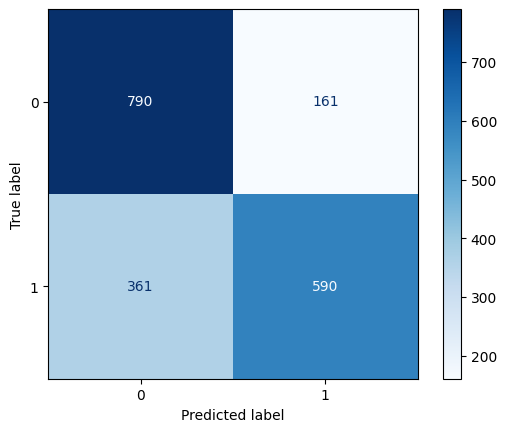

In [1046]:
cm = confusion_matrix(Y_smote1, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [1047]:
y_pred_test = neigh.predict(X_test1_knn) # y_pred = arbol.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test1, y_pred_test))
print("Recall: {}".format(recall_score(Y_test1,y_pred_test)))
print("Precisión: {}".format(precision_score(Y_test1,y_pred_test)))
print("Puntuación F1: {}".format(f1_score(Y_test1,y_pred_test)))

Exactitud: 0.56
Recall: 0.4043478260869565
Precisión: 0.7099236641221374
Puntuación F1: 0.5152354570637119


In [1048]:
print(classification_report(Y_test1, y_pred_test))

              precision    recall  f1-score   support

           0       0.49      0.78      0.60       170
           1       0.71      0.40      0.52       230

    accuracy                           0.56       400
   macro avg       0.60      0.59      0.56       400
weighted avg       0.62      0.56      0.55       400



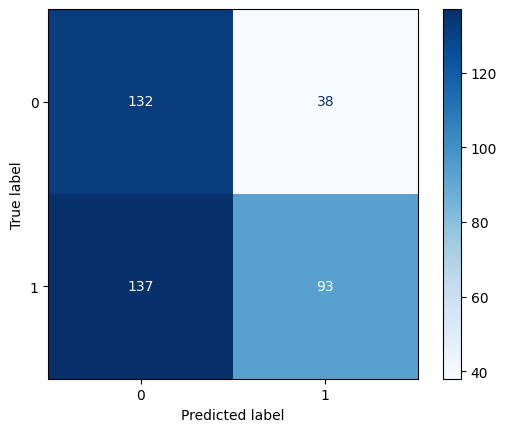

In [1049]:
cm = confusion_matrix(Y_test1, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definir el modelo base
neigh = KNeighborsClassifier()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos a probar
    'weights': ['uniform', 'distance'],  # Pesos en la clasificación
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Tipos de distancia
}

# Crear el modelo de búsqueda
grid_search = GridSearchCV(estimator=neigh, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Ajustar GridSearch con los datos balanceados
grid_search.fit(X_smote1_knn, Y_smote1) 

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Usar el mejor modelo encontrado
best_knn = grid_search.best_estimator_

# Evaluar en los datos de prueba
y_pred_test = best_knn.predict(X_test1_knn)

print('Exactitud: %.2f' % accuracy_score(Y_test1, y_pred_test))
print("Recall:", recall_score(Y_test1, y_pred_test))
print("Precisión:", precision_score(Y_test1, y_pred_test))
print("Puntuación F1:", f1_score(Y_test1, y_pred_test))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

## 4.2 Arboles de decision

In [ ]:
## 